## Dog Vs Cat Classification Using CNN

In [40]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
# #         print(os.path.join(dirname, filename))

# import zipfile

# with zipfile.ZipFile("/kaggle/input/catvsdog.zip","r") as z:
#     z.extractall(".")

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# main_dir = "/kaggle/input/catvsdog/"
# train_dir = "train"
path ="/kaggle/input/catvsdog/train/"

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import os
import random
from tensorflow.keras.preprocessing.image import load_img

In [4]:
# gather images into a dataframe
filenames = os.listdir(path)
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append('dog')
    else:
        categories.append('cat')

all_df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [5]:
all_df.head(10)

,filename,category
0,dog.3501.jpg,dog
1,dog.5601.jpg,dog
2,dog.6569.jpg,dog
3,dog.4515.jpg,dog
4,cat.7291.jpg,cat
5,dog.8897.jpg,dog
6,dog.11459.jpg,dog
7,cat.3457.jpg,cat
8,cat.8530.jpg,cat
9,dog.8519.jpg,dog


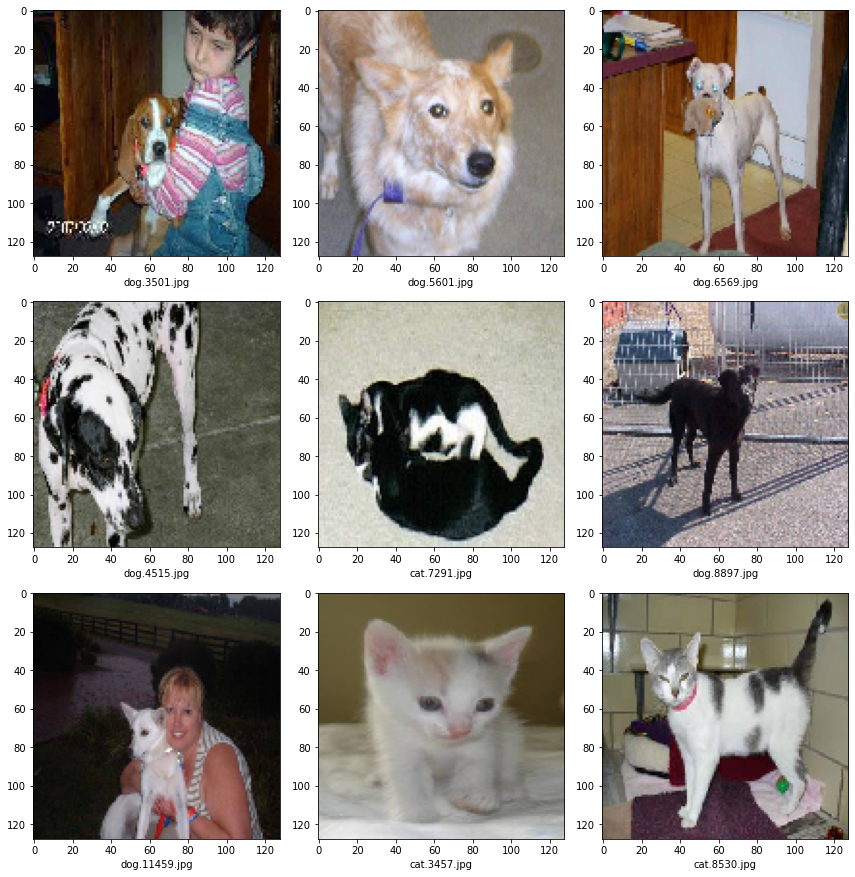

In [6]:
sample = all_df.head(9)
sample.head()
plt.figure(figsize=(12, 24))
for index, row in sample.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img(path+filename, target_size=(128,128))
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename)
plt.tight_layout()
plt.show()

In [7]:
# show counts for each category
all_df['category'].value_counts()

dog    12500
cat    12500
Name: category, dtype: int64

In [8]:
from sklearn.model_selection import train_test_split
# split into train/validate and test sets
train_validate, test_df = train_test_split(all_df, test_size=0.10, random_state=0)
train_validate = train_validate.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [9]:
test_df['category'].value_counts()

dog    1295
cat    1205
Name: category, dtype: int64

In [10]:
train_df, validate_df = train_test_split(train_validate, test_size=0.20, random_state=0)
train_df = train_df.reset_index(drop=True)

validate_df = validate_df.reset_index(drop=True)

In [11]:
train_df['category'].value_counts()

cat    9063
dog    8937
Name: category, dtype: int64

In [12]:
validate_df['category'].value_counts()

dog    2268
cat    2232
Name: category, dtype: int64

In [13]:
import tensorflow.keras.preprocessing.image as image
train_datagen = image.ImageDataGenerator(rescale=1./255)
validate_datagen = image.ImageDataGenerator(rescale=1./255)
test_datagen = image.ImageDataGenerator(rescale=1./255)

In [14]:
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "/kaggle/input/catvsdog/train/", 
    x_col='filename',
    y_col='category',
    target_size=(128, 128),
    class_mode='binary',
    batch_size=150
)

Found 18000 validated image filenames belonging to 2 classes.


In [15]:
validation_generator = validate_datagen.flow_from_dataframe(
    validate_df,
   "/kaggle/input/catvsdog/train/", 
    x_col='filename',
    y_col='category',
    target_size=(128, 128),
    class_mode='binary',
    batch_size=50
)

Found 4500 validated image filenames belonging to 2 classes.


In [16]:
test_generator = test_datagen.flow_from_dataframe(
    test_df, 
    "/kaggle/input/catvsdog/train/",
    x_col='filename',
    y_col='category',
    target_size=(128,128),
    class_mode='binary',
    batch_size=50
)

Found 2500 validated image filenames belonging to 2 classes.


## Basic CNN model

In [17]:
from tensorflow.keras import layers
from tensorflow.keras import models
model = models.Sequential()


model.add(layers.Conv2D(32, (3, 3), activation='relu',
input_shape=(128, 128, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())


model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       7

In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model1.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [19]:
import tensorflow.keras.optimizers as optimizers
model.compile(loss='binary_crossentropy',
optimizer=optimizers.Adam(),
metrics=['acc'])

In [20]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch=100,
        epochs=30,
        validation_data=validation_generator,
        validation_steps=100,
        callbacks=callbacks,)

Epoch 1/30
100/100 [==============================] - ETA: 0s - loss: 0.6655 - acc: 0.5799
Epoch 00001: val_loss improved from inf to 0.62276, saving model to model1.h5
100/100 [==============================] - 86s 859ms/step - loss: 0.6655 - acc: 0.5799 - val_loss: 0.6228 - val_acc: 0.6533
Epoch 2/30
100/100 [==============================] - 48s 476ms/step - loss: 0.5812 - acc: 0.6832
Epoch 3/30
100/100 [==============================] - 44s 441ms/step - loss: 0.5077 - acc: 0.7507
Epoch 4/30
100/100 [==============================] - 46s 460ms/step - loss: 0.4523 - acc: 0.7889
Epoch 5/30
100/100 [==============================] - 43s 427ms/step - loss: 0.4064 - acc: 0.8154
Epoch 6/30
100/100 [==============================] - 43s 431ms/step - loss: 0.3846 - acc: 0.8267
Epoch 7/30
100/100 [==============================] - 44s 440ms/step - loss: 0.3432 - acc: 0.8502
Epoch 8/30
100/100 [==============================] - 43s 434ms/step - loss: 0.3365 - acc: 0.8495
Epoch 9/30
100/100 [=

ValueError: x and y must have same first dimension, but have shapes (30,) and (1,)

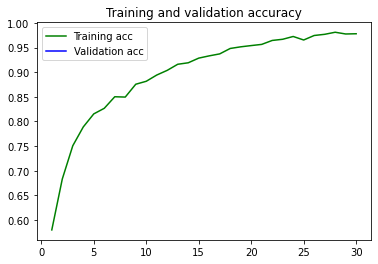

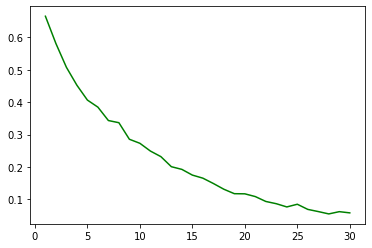

In [25]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
epochs_val = range(1, len(val_acc) + 1)
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs_val, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [22]:
test_loss, test_acc = model.evaluate_generator(test_generator, steps=100)
print('test acc:', test_acc)
# Test accuracy of 90.4% (pretty decent considering self made model ;)

test acc: 0.9039999842643738


> ## CNN with Transfer Learning (VGG16)

In [27]:
from keras.models import Sequential
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.applications import VGG16
from keras.models import Model

In [28]:
image_size = 224 # Input Image size of 224 fixed for VGG16
input_shape = (image_size, image_size, 3)

epochs = 5
batch_size = 16

# Using pre-trained model VGG16 with pre initialized weights from imagenet
pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")

# Freezing the per-trained models for 15 layers to prevent changing any data
for layer in pre_trained_model.layers[:15]:
    layer.trainable = False

# Training over only new layers taking predictions from Freezed model
for layer in pre_trained_model.layers[15:]:
    layer.trainable = True
    
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output

58892288/58889256 [==============================] - 0s 0us/step


In [29]:
# Flattening the output layer to 1 dimension
x = GlobalMaxPooling2D()(last_output)

# Adding a fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)

# Adding a dropout rate of 0.5
x = Dropout(0.5)(x)

# Adding a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)


model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [30]:

# validate_df = validate_df.sample(n=100).reset_index() # use for fast testing code purpose
# train_df = train_df.sample(n=1800).reset_index() # use for fast testing code purpose

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

In [31]:
# Re initalizing data generator of Training set with extra parameters
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "/kaggle/input/catvsdog/train/", 
    x_col='filename',
    y_col='category',
    target_size=(image_size, image_size),
    class_mode='binary',
    batch_size=batch_size
)

Found 18000 validated image filenames belonging to 2 classes.


In [33]:
validation_generator = validate_datagen.flow_from_dataframe(
    validate_df, 
    "/kaggle/input/catvsdog/train/", 
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 4500 validated image filenames belonging to 2 classes.


In [34]:
test_generator = test_datagen.flow_from_dataframe(
    test_df, 
    "/kaggle/input/catvsdog/train/", 
    x_col='filename',
    y_col='category',
    class_mode='binary',
    batch_size=batch_size,
    target_size=(image_size, image_size),
    shuffle=False
)

Found 2500 validated image filenames belonging to 2 classes.


In [35]:
history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size)

Epoch 1/5
1125/1125 [==============================] - 290s 257ms/step - loss: 0.3372 - accuracy: 0.8402 - val_loss: 0.1441 - val_accuracy: 0.9408
Epoch 2/5
1125/1125 [==============================] - 289s 257ms/step - loss: 0.1675 - accuracy: 0.9329 - val_loss: 0.1115 - val_accuracy: 0.9535
Epoch 3/5
1125/1125 [==============================] - 288s 256ms/step - loss: 0.1386 - accuracy: 0.9447 - val_loss: 0.1087 - val_accuracy: 0.9551
Epoch 4/5
1125/1125 [==============================] - 292s 260ms/step - loss: 0.1201 - accuracy: 0.9517 - val_loss: 0.1081 - val_accuracy: 0.9564
Epoch 5/5
1125/1125 [==============================] - 290s 258ms/step - loss: 0.1095 - accuracy: 0.9567 - val_loss: 0.0898 - val_accuracy: 0.9637


In [36]:
loss, accuracy = model.evaluate_generator(validation_generator, total_validate//batch_size, workers=12)
print("Train_Val: accuracy = %f  ;  loss = %f " % (accuracy, loss))

Train_Val: accuracy = 0.963746  ;  loss = 0.089781 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  app.launch_new_instance()


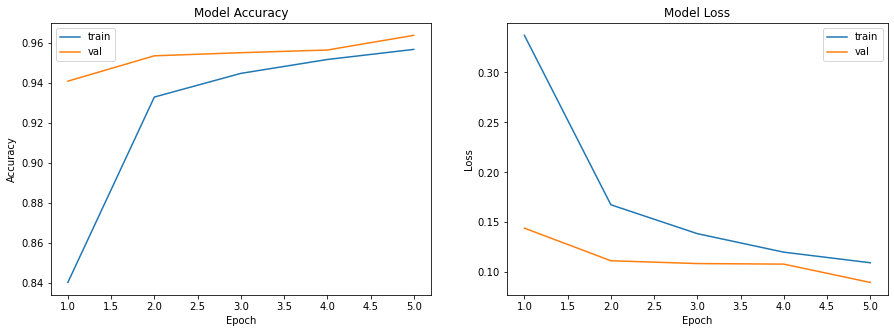

In [37]:
# Plotting graphs for train/val accuracy and loss
def plot_model_history(model_history, acc='accuracy', val_acc='val_accuracy'):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(model_history.history[acc])+1),model_history.history[acc])
    axs[0].plot(range(1,len(model_history.history[val_acc])+1),model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history[acc])+1),len(model_history.history[acc])/10)
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

plot_model_history(history)

In [38]:
test_loss, test_acc = model.evaluate_generator(test_generator, steps=100)
print('test acc:', test_acc)
# Test accuracy of 96.62% using VGG16

test acc: 0.9662500023841858


## Conclusion

* Using custom made CNN model -  Test accuracy=90.4%
* Using VGG16 PreTrained Model -  Test Accuracy = 96.62%


I wanted to test more networks like ResNet, Inception for better performance but I m still learning those(Understanding their different hyperparameters and Overall model),so i didn't want to use any NN which i dont Understand yet.